In [39]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:95% !important; }</style>"))

In [40]:
from collections import Counter
from itertools import chain
import pandas as pd
import numpy as np
import nltk
from ipywidgets import Output
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import LdaModel
from gensim.models import Phrases
from itertools import chain
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import networkx as nx

In [61]:
sns.set_style()

In [41]:
%%time
train = pd.read_csv('../data/external/kaggle/train.csv')
test = pd.read_csv('../data/external/kaggle/test.csv')
y = pd.read_csv('../data/external/kaggle/train.csv')['target'].values
tokenizer = TweetTokenizer()


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as SKLEARN_STOPWORDS
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOPWORDS
from nltk.corpus import stopwords

SKLEARN_STOPWORDS = set(SKLEARN_STOPWORDS)
out = Output()
with out:
    nltk.download('stopwords')
NLTK_STOPWORDS = set(stopwords.words('english'))
print(f'Loaded {len(NLTK_STOPWORDS)} stopwords from NLTK')
print(f'Loaded {len(SPACY_STOPWORDS)} stopwords from SPACY')
print(f'Loaded {len(SKLEARN_STOPWORDS)} stopwords from SKLEARN')
stop_words = list(set.union(*[SKLEARN_STOPWORDS, SPACY_STOPWORDS, NLTK_STOPWORDS]))
print('----------------------------------')
print(f'{len(stop_words)} combined stopwords')

Loaded 179 stopwords from NLTK
Loaded 326 stopwords from SPACY
Loaded 318 stopwords from SKLEARN
----------------------------------
409 combined stopwords
CPU times: user 208 ms, sys: 36 ms, total: 244 ms
Wall time: 420 ms


In [42]:
%%time
corpus = train['text'].values
corpus = [doc.lower() for doc in corpus]
corpus = [tokenizer.tokenize(doc) for doc in corpus]
corpus = [[token for token in doc if (not token.isnumeric() and len(token) > 1)] for doc in corpus]
corpus= [[token for token in doc if (not token in stop_words)] for doc in corpus]
bigram = Phrases(corpus, min_count=1)
trigram = Phrases(bigram[corpus], min_count=1)
fourgram = Phrases(trigram[corpus], min_count=1)
bigrams = []
trigrams = []
fourgrams = []
for doc in corpus:
    b = [b for b in bigram[doc] if b.count('_') == 1]
    t = [t for t in trigram[bigram[doc]] if t.count('_') == 2]
    f = [f for f in fourgram[trigram[bigram[doc]]] if f.count('_') == 3]
    bigrams.extend(b)
    trigrams.extend(t)
    fourgrams.extend(f)

CPU times: user 3.67 s, sys: 3.59 ms, total: 3.67 s
Wall time: 3.67 s


In [43]:
%%time
unigrams = Counter(chain(*corpus))

CPU times: user 9.49 ms, sys: 115 µs, total: 9.61 ms
Wall time: 9.62 ms


In [59]:
to_plot = unigrams.most_common(1000)
to_plot = list(dict(to_plot).values())
y= np.arange(len(to_plot))

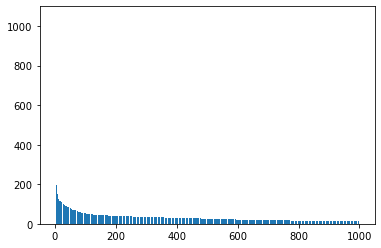

In [65]:
fig = plt.figure()
plt.bar(y, to_plot);

In [20]:
frequency.most_common(10)

[('http', 4309),
 ('https', 411),
 ('like', 348),
 ('û_', 348),
 ('amp', 344),
 ('new', 226),
 ('people', 200),
 ('news', 197),
 ('video', 165),
 ('disaster', 158)]

In [5]:
Counter(bigrams).most_common(10)

[('û_', 77),
 ('suicide_bomber', 49),
 ('burning_buildings', 48),
 ('liked_youtube', 42),
 ('heat_wave', 31),
 ('california_wildfire', 31),
 ('natural_disaster', 30),
 ('prebreak_best', 30),
 ('mass_murder', 30),
 ('looks_like', 28)]

In [6]:
Counter(trigrams).most_common(10)

[('û__http', 150),
 ('liked_youtube_video', 35),
 ('û__https', 33),
 ('black_hat_http', 17),
 ('pamela_geller_http', 15),
 ('ambulance_helicopter_crash', 14),
 ('bigger_projected_http', 14),
 ('read_ebay_http', 12),
 ('subreddits_banned_quarantined', 11),
 ('hiroshima_atomic_bombing', 10)]

In [21]:
Counter(fourgrams).most_common(10)

[('latest_homes_razed_northern', 27),
 ('families_sue_legionnaires_families', 25),
 ('watch_airport_swallowed_sandstorm', 24),
 ('wreckage_conclusively_confirmed_mh370', 24),
 ('affected_fatal_outbreak_legionnaires', 22),
 ('obama_declares_disaster_typhoon-devastated', 21),
 ('malaysia_pm_investigators_families', 20),
 ('suicide_bomber_detonated_bomb', 19),
 ('refugio_oil_spill_costlier', 18),
 ("video_we're_picking_bodies", 18)]

In [22]:
df = pd.DataFrame(Counter(bigrams).most_common()).rename(columns={0:'bigrams', 1:'weight'})
df[['a', 'b']] = df['bigrams'].str.split(pat='_', expand=True)
df = df[['a','b','weight']]
df = df.replace('', np.nan).dropna().reset_index(drop=True)
df

a          b  weight
0           suicide     bomber      46
1           burning  buildings      44
2             liked   @youtube      41
3              heat       wave      30
4         #prebreak      #best      30
...             ...        ...     ...
3541         @mount      wario       1
3542            @jt     ruff23       1
3543  #thunderstorm   warnings       1
3544          parts        #ar       1
3545            #nc        #ok       1

[3546 rows x 3 columns]

In [23]:
G = nx.from_pandas_edgelist(df, 'a', 'b', 'weight')

In [28]:
nx.set_node_attributes(G, unigrams, 'frequency')

In [36]:
nx.write_graphml(G, '../data/processed/bigrams_with_frequency.graphml')

In [45]:
# from networkx.readwrite import json_graph
# import json
# data = json_graph.node_link_data(G)
# js = json.dumps(data)

In [68]:
components = list(nx.connected_components(G))
largest_component = components[0]
subgraph = G.subgraph(largest_component)

In [70]:
nx.write_graphml(subgraph, '../data/processed/bigrams_with_frequency_largest_component.graphml')

In [76]:
subgraph_stats = pd.read_csv('../data/processed/subgraph_stats.csv')
subgraph_stats.sample(5)

AverageShortestPathLength  BetweennessCentrality  ClosenessCentrality  \
197                   10.297450               0.003772             0.097111   
403                    7.099150               0.002831             0.140862   
601                    5.751653               0.009476             0.173863   
1408                   7.008499               0.000000             0.142684   
595                    6.857885               0.000000             0.145818   

      ClusteringCoefficient  Degree  degree.layout  Eccentricity  frequency  \
197                     0.0       3              3            17       28.0   
403                     0.0       3              3            16       28.0   
601                     0.0       5              5            17       23.0   
1408                    0.0       1              1            16        3.0   
595                     0.0       1              1            19        5.0   

      IsSingleNode   name  NeighborhoodConnectivity  NumberOfDirectedEdges  \
197          False   wake                  2.000000                      0   
403          False  words                  2.666667                      0   
601          False  china                  6.200000                      0   
1408         False   lock                  8.000000                      0   
595          False   yobe                  4.000000                      0   

      NumberOfUndirectedEdges  PartnerOfMultiEdgedNodePairs  Radiality  \
197                         3                             0   0.778632   
403                         3                             0   0.854782   
601                         5                             0   0.886865   
1408                        1                             0   0.856941   
595                         1                             0   0.860527   

      selected  SelfLoops shared name  Stress  TopologicalCoefficient  
197      False          0        wake   83602                0.500000  
403      False          0       words   24964                0.333333  
601      False          0       china  103840                0.200000  
1408     False          0        lock       0                0.000000  
595      False          0        yobe       0                0.000000

In [77]:
subgraph_stats.describe()

AverageShortestPathLength  BetweennessCentrality  ClosenessCentrality  \
count                2119.000000            2119.000000          2119.000000   
mean                    7.419200               0.003032             0.138090   
std                     1.285349               0.007291             0.020002   
min                     5.058074               0.000000             0.054936   
25%                     6.553824               0.000000             0.125948   
50%                     7.205855               0.000319             0.138776   
75%                     7.939802               0.002831             0.152583   
max                    18.203022               0.083782             0.197704   

       ClusteringCoefficient       Degree  degree.layout  Eccentricity  \
count            2119.000000  2119.000000    2119.000000   2119.000000   
mean                0.011108     2.501180       2.495517     18.387919   
std                 0.084017     2.718432       2.710427      1.598974   
min                 0.000000     1.000000       1.000000     13.000000   
25%                 0.000000     1.000000       1.000000     17.000000   
50%                 0.000000     2.000000       2.000000     18.000000   
75%                 0.000000     3.000000       3.000000     19.000000   
max                 1.000000    42.000000      42.000000     25.000000   

         frequency  NeighborhoodConnectivity  NumberOfDirectedEdges  \
count  2071.000000               2119.000000                 2119.0   
mean     17.649928                  6.450415                    0.0   
std      31.745084                  6.493004                    0.0   
min       1.000000                  1.250000                    0.0   
25%       4.000000                  3.000000                    0.0   
50%       9.000000                  4.500000                    0.0   
75%      23.000000                  7.000000                    0.0   
max    1047.000000                 42.000000                    0.0   

       NumberOfUndirectedEdges  PartnerOfMultiEdgedNodePairs    Radiality  \
count              2119.000000                        2119.0  2119.000000   
mean                  2.495517                           0.0     0.847162   
std                   2.710427                           0.0     0.030604   
min                   1.000000                           0.0     0.590404   
25%                   1.000000                           0.0     0.834767   
50%                   2.000000                           0.0     0.852242   
75%                   3.000000                           0.0     0.867766   
max                  42.000000                           0.0     0.903379   

         SelfLoops        Stress  TopologicalCoefficient  
count  2119.000000  2.119000e+03             2119.000000  
mean      0.005663  3.156555e+04                0.185125  
std       0.075058  7.813177e+04                0.207276  
min       0.000000  0.000000e+00                0.000000  
25%       0.000000  0.000000e+00                0.000000  
50%       0.000000  3.550000e+03                0.107407  
75%       0.000000  2.821000e+04                0.333333  
max       1.000000  1.040518e+06                0.700000

In [97]:
subgraph_stats.sort_values(by=['ClosenessCentrality'])[['name']].head(15)

name
1953                  reward
1754              #afterlife
1951                  saving
394                   #islam
1050                     #ap
393                     #cnn
1047               #hostages
1051                    #trs
1621               #breaking
1600               #pakistan
953   http://t.co/cedcugeuws
1311              #australia
1049                 #africa
392                     #bbc
507                  mishaps

>Radiality centrality will give high centralities to vertices that are a short distance to every other vertex in its reachable neighborhood compared to its diameter.
Radiality out-centrality for a vertex i is computed using the out component gi for the vertex i and is given by (Σj d-dij+1 / (d(n-1)), where dij  is the distance from i to j in gi, d is the diameter of gi, and the sum is over the vertices in gi.

source: https://www.centiserver.org/?q1=centrality&q2=Radiality_Centrality

In [90]:
subgraph_stats.sort_values(by=['Radiality'])[['name']].head(20)

name
1953                  reward
1754              #afterlife
1951                  saving
394                   #islam
1050                     #ap
393                     #cnn
1047               #hostages
1051                    #trs
1621               #breaking
1600               #pakistan
953   http://t.co/cedcugeuws
1311              #australia
1049                 #africa
392                     #bbc
507                  mishaps
866                    faced
1021                    olap
391                    #news
1593                  alaska
163                      lab

In [94]:
subgraph_stats.sort_values(by=['AverageShortestPathLength'])[['name']].head(15)

name
136      killed
387      caused
40    emergency
79       police
249      people
571         ûªs
8    california
317      attack
177         new
302         car
222        dead
336     injured
127     nuclear
105  derailment
224         i'm

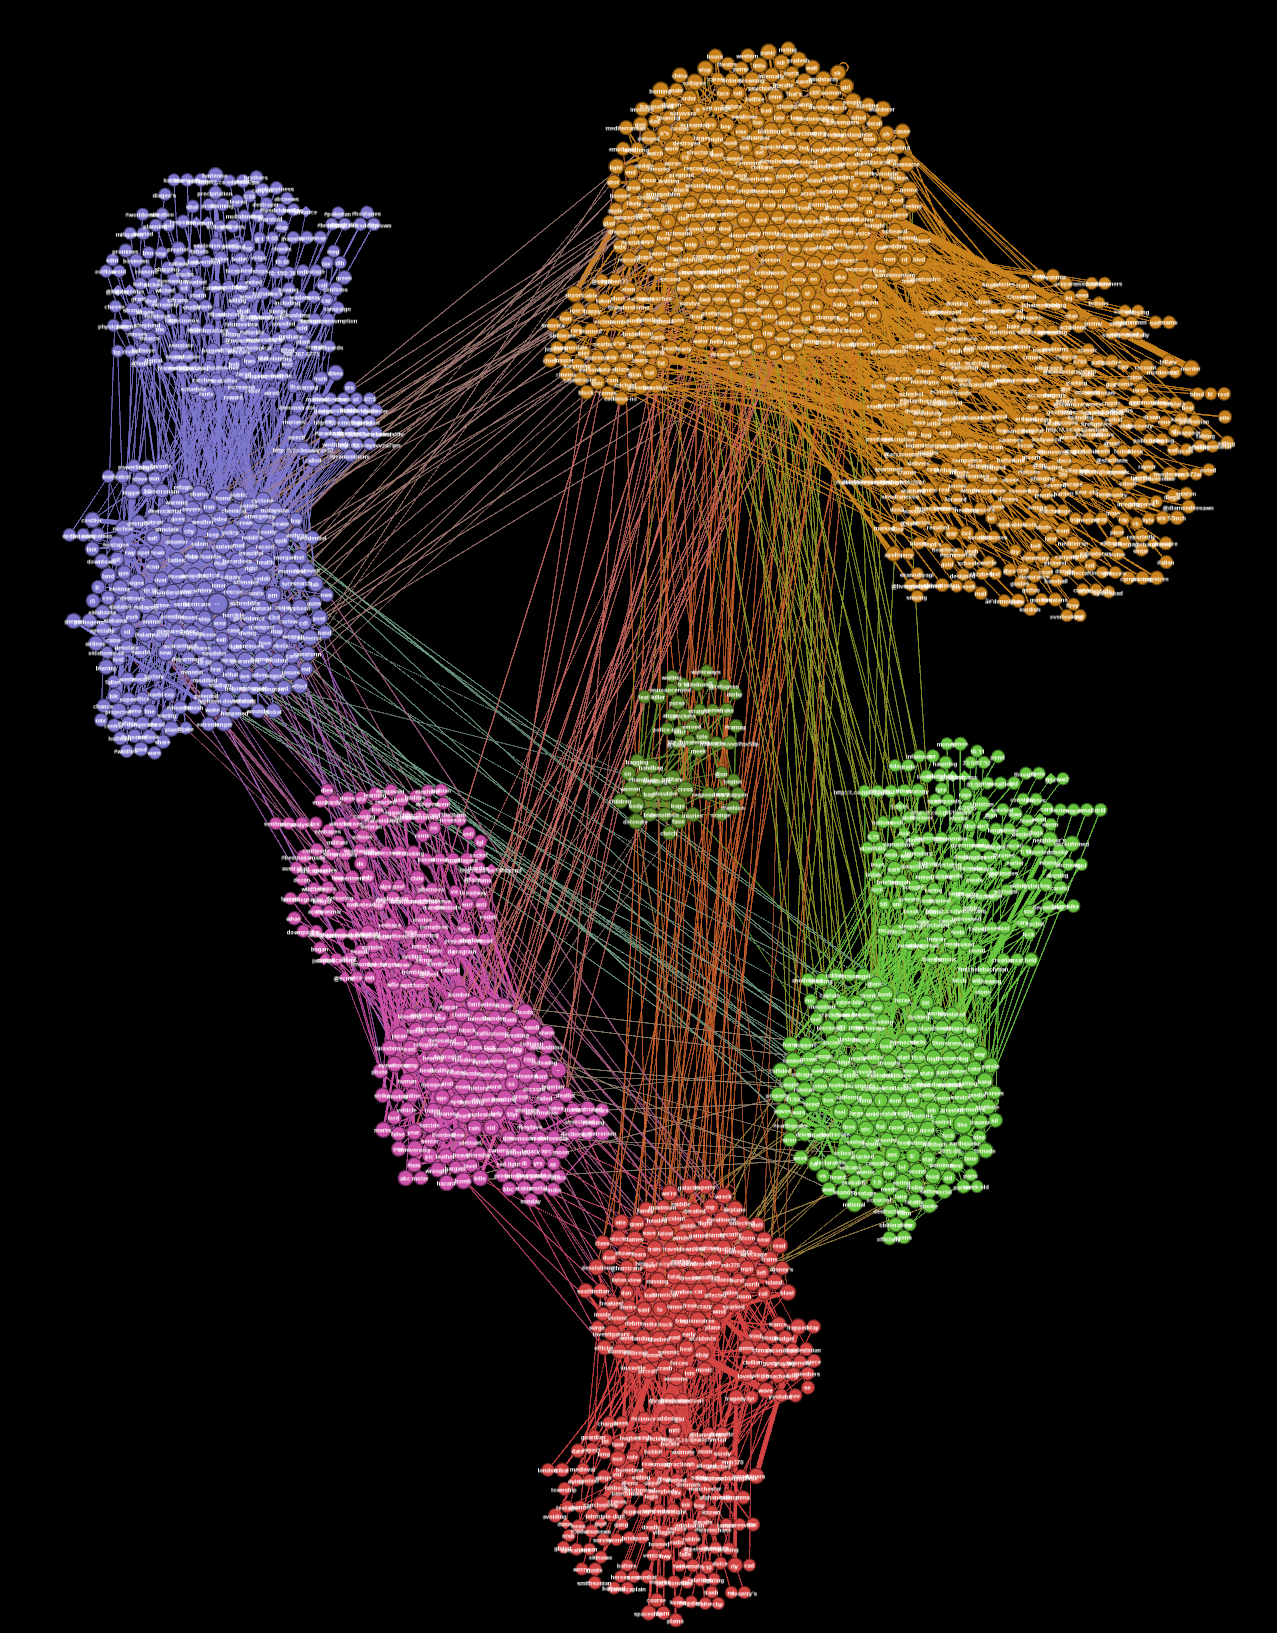

In [38]:
Image('../reports/gephi_reports/screenshots/network.png')

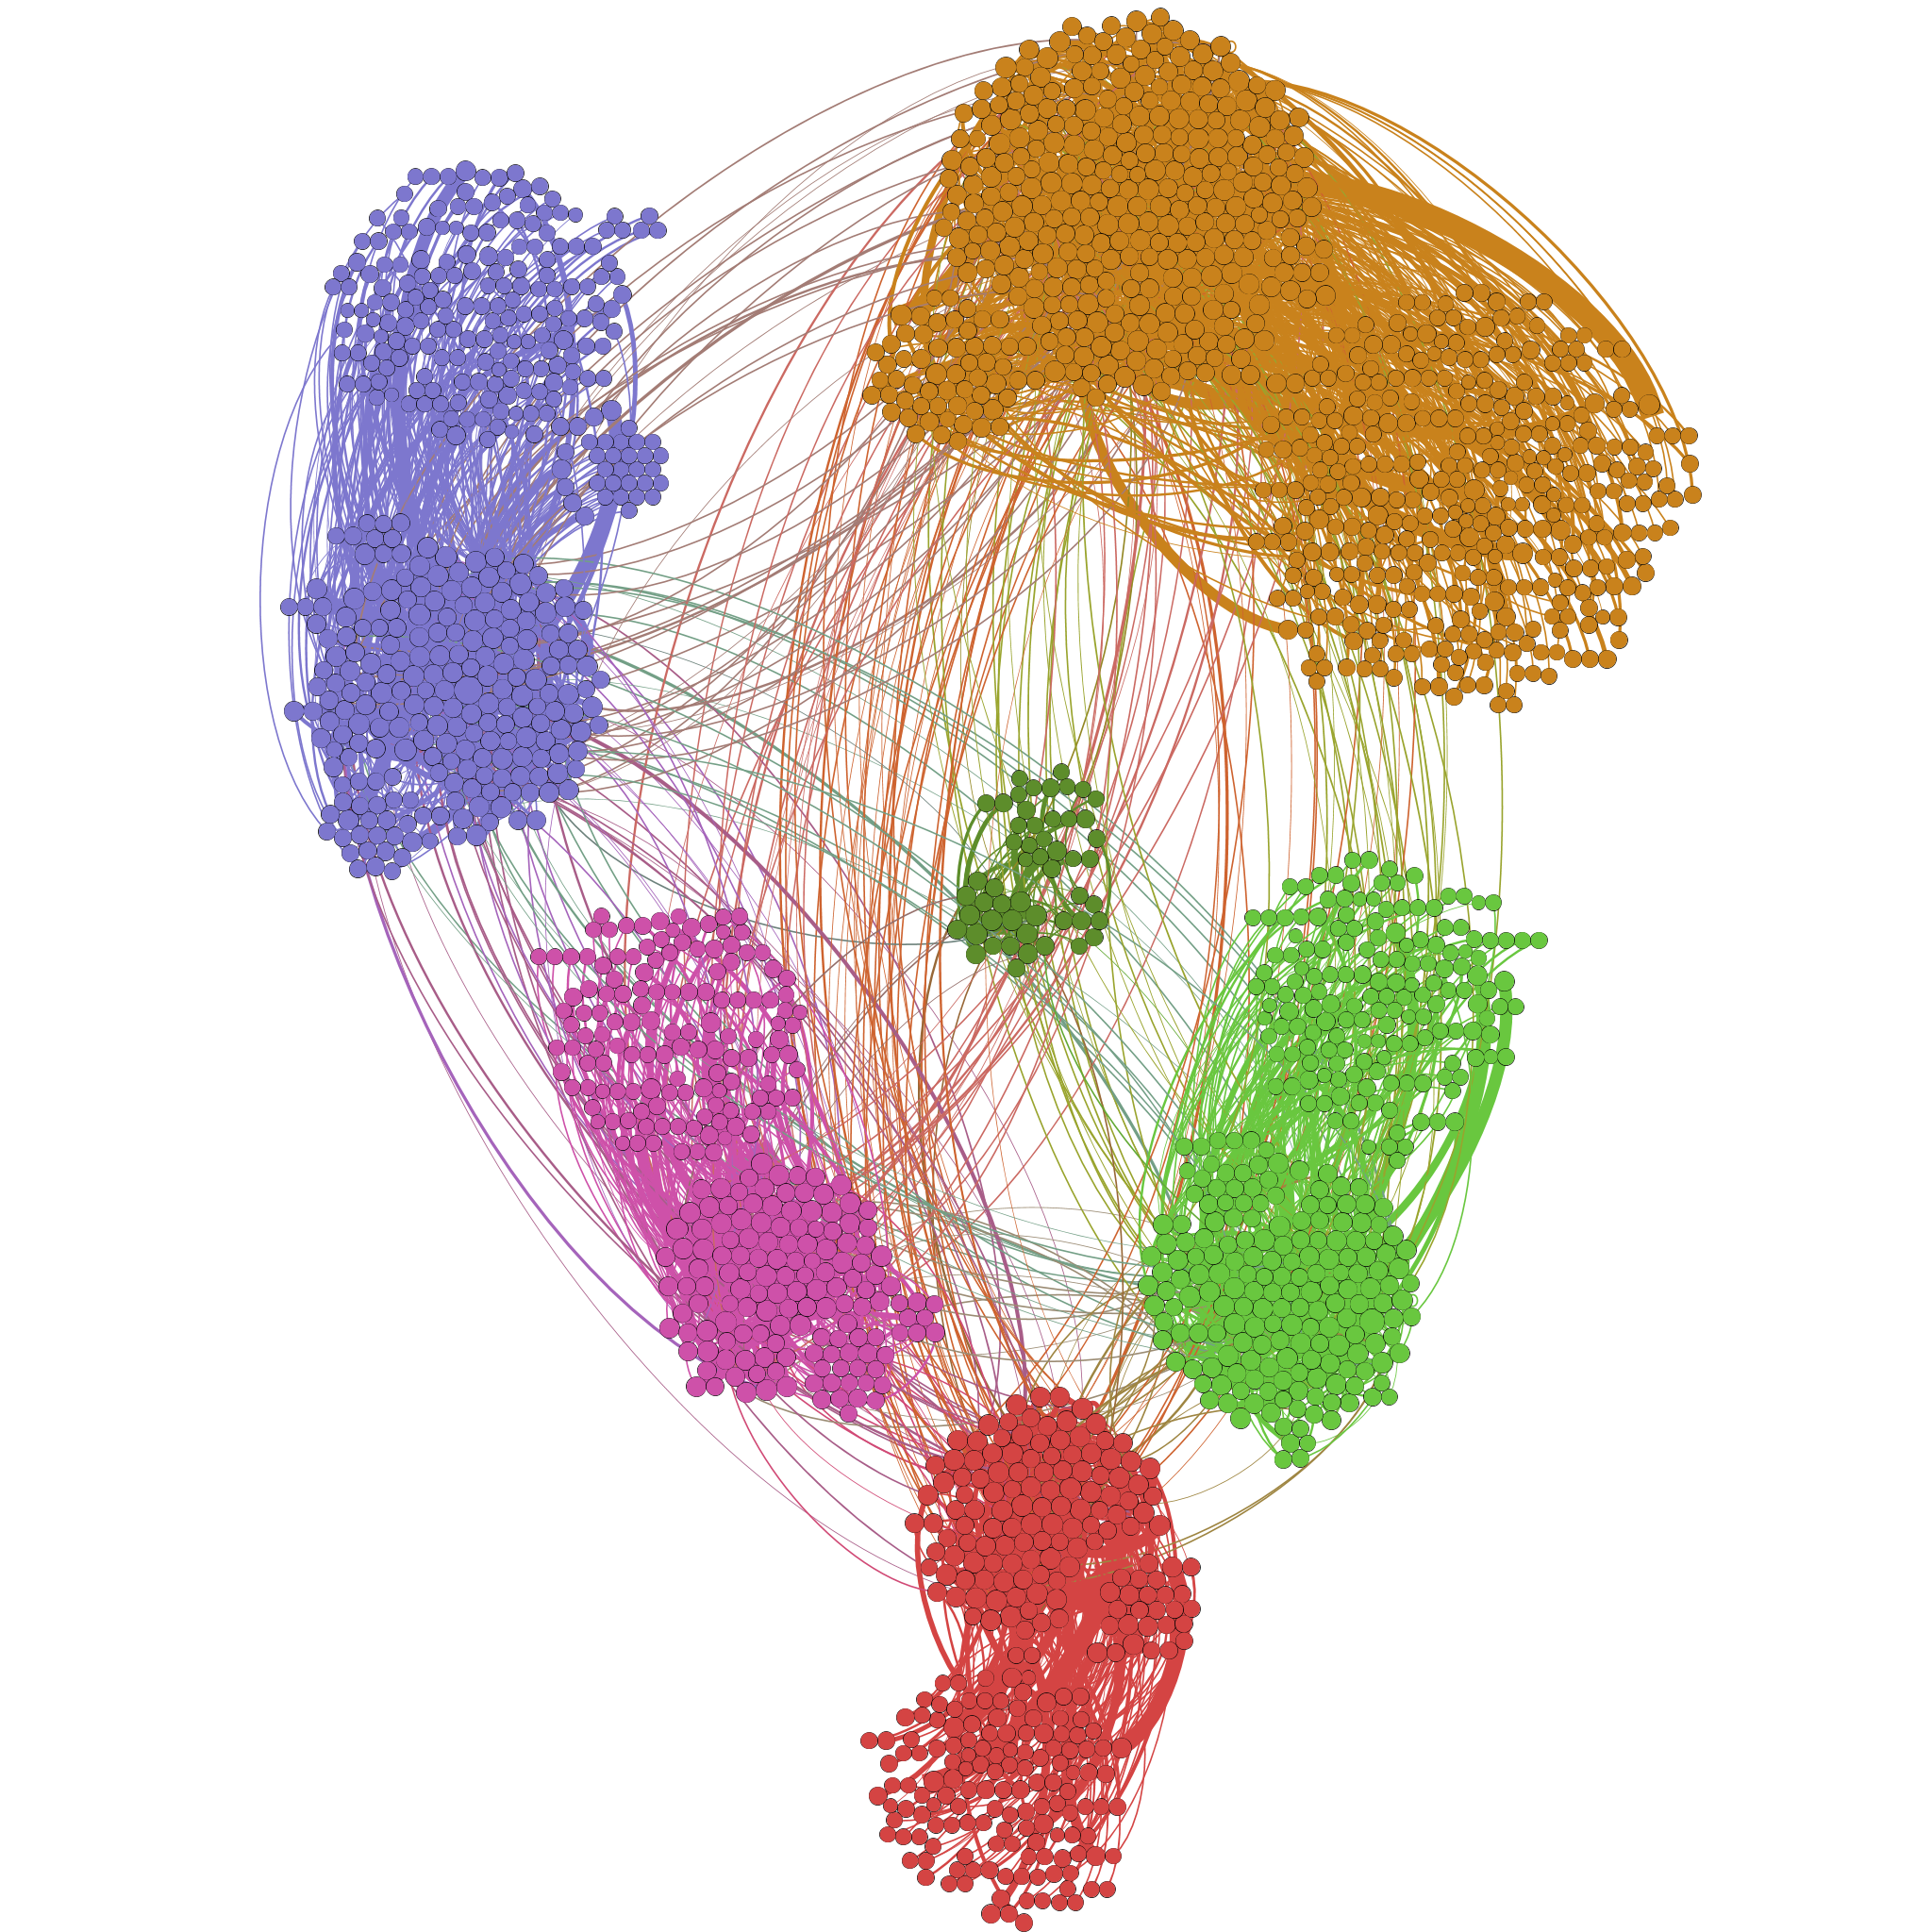

In [7]:
Image('../reports/gephi_reports/exported/no_labels.png')

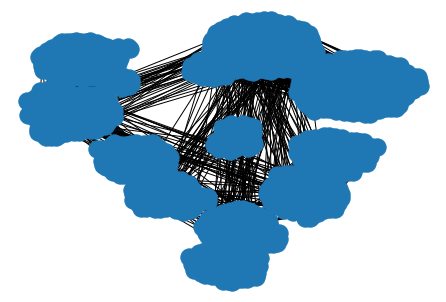

In [37]:
processed_graph = nx.read_graphml('../data/processed/processed.graphml')
pos = {l:(d['x'], d['y']) for l,d in processed_graph.nodes(data=True)}
nx.draw(processed_graph, pos=pos)